In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]

class InDIModel(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""
    def __init__(self, channels=[32, 64, 128, 256], embed_dim=256):
        super().__init__()
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim), nn.Linear(embed_dim, embed_dim))
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
        self.act = lambda x: x * torch.sigmoid(x)

    def forward(self, x, t):
        embed = self.act(self.embed(t))
        h1 = self.conv1(x)
        h1 = h1 + self.dense1(embed).expand_as(h1)
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 = h2 + self.dense2(embed).expand_as(h2)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 = h3 + self.dense3(embed).expand_as(h3)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 = h4 + self.dense4(embed).expand_as(h4)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)
        h = self.tconv4(h4)
        h = h + self.dense5(embed).expand_as(h)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h = h + self.dense6(embed).expand_as(h)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h = h + self.dense7(embed).expand_as(h)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))
        return h

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
batch_size = 64

model = InDIModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def degrade_image(image, t):
    noise = torch.randn_like(image)
    t = t.view(-1, 1, 1, 1).expand_as(image)
    return (1 - t) * image + t * noise + torch.randn_like(image, device=image.device) *0.01* torch.sqrt(t) *torch.sqrt(t)

epochs = 10
steps = 100
t_values = torch.linspace(0, 1, steps, device=device)

for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        data = data.to(device)
        random_indices = torch.randperm(steps)[:data.size(0)]
        t = t_values[random_indices].to(device)
        degraded_data = degrade_image(data, t)
        optimizer.zero_grad()
        output = model(degraded_data, t)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')




Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4483363.72it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133839.91it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1263978.53it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5453916.05it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1/10, Loss: 0.03729935362935066
Epoch 2/10, Loss: 0.03805648162961006
Epoch 3/10, Loss: 0.03254499286413193
Epoch 4/10, Loss: 0.0315808467566967
Epoch 5/10, Loss: 0.036796849220991135
Epoch 6/10, Loss: 0.030473358929157257
Epoch 7/10, Loss: 0.03355070576071739
Epoch 8/10, Loss: 0.03352823108434677
Epoch 9/10, Loss: 0.030424538999795914
Epoch 10/10, Loss: 0.02834477834403515


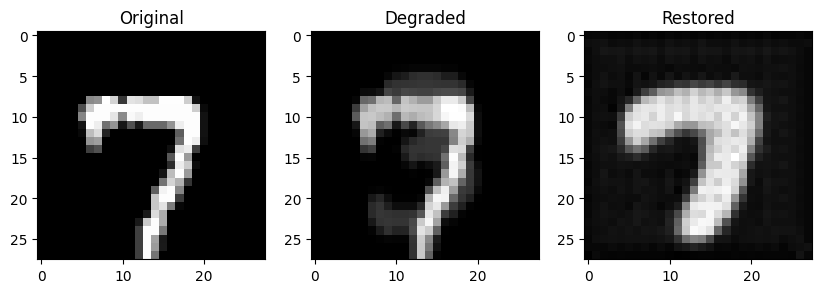

In [2]:
import matplotlib.pyplot as plt
import cv2

def restore_image(model, degraded_image, steps=100):
    model.eval()
    with torch.no_grad():
        restored_image = degraded_image + torch.randn_like(degraded_image) * 0.01
        delta = 1 / steps
        for step in range(steps):
            t = torch.full((degraded_image.size(0),), 1 - step * delta, device=degraded_image.device)
            epsilon_t = 0.01/(torch.sqrt(t))

            if 0 in torch.sqrt(t - delta):
                epsilon_t_minus_delta = 0
            else:
                epsilon_t_minus_delta = 0.01/(torch.sqrt(t - delta))

            zeta = torch.randn_like(restored_image)
            t_tensor = t.view(-1, 1, 1, 1).expand_as(degraded_image)
            F_theta = model(restored_image, t)
            if 0 in torch.sqrt(t - delta):
                noise_term = 0
            else:
                noise_term = (torch.sqrt(epsilon_t_minus_delta ** 2 - epsilon_t ** 2)[:, None, None, None] * zeta)
            restored_image = (delta / t.view(-1, 1, 1, 1)) * F_theta + ((1 - delta / t.view(-1, 1, 1, 1)) * restored_image) + (t.view(-1, 1, 1, 1)-delta)*noise_term
    return restored_image


example_data, _ = next(iter(train_loader))
example_data = example_data.to(device)
#degraded_example = degrade_image(example_data, torch.tensor(1.0).to(device))
kernel_size = 3

degraded_example = cv2.GaussianBlur(example_data.cpu().numpy().squeeze() , (kernel_size, kernel_size), sigmaX=0.5)
degraded_example = torch.tensor(degraded_example).unsqueeze(1).cuda()
restored_example = restore_image(model, degraded_example)

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].imshow(example_data[0].cpu().squeeze(), cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(degraded_example[0].cpu().squeeze(), cmap='gray')
axes[1].set_title('Degraded')
axes[2].imshow(restored_example[0].cpu().squeeze(), cmap='gray')
axes[2].set_title('Restored')
plt.show()

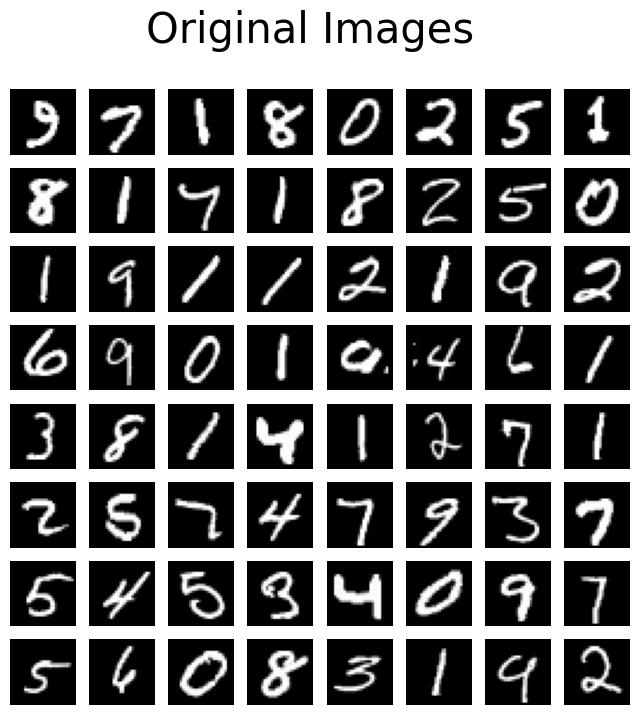

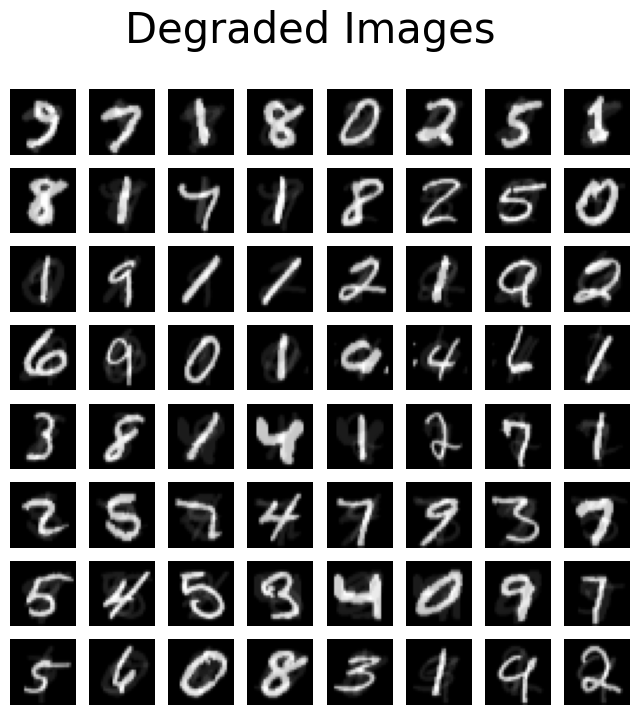

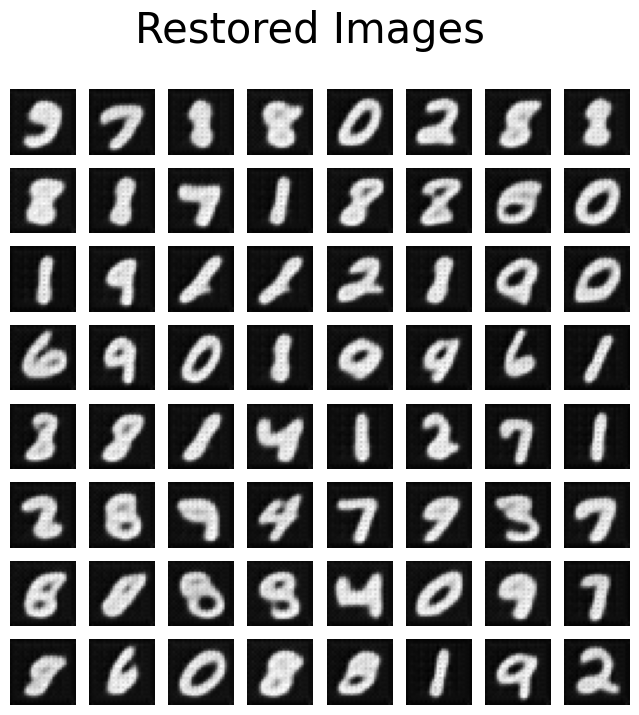

In [3]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""
    images = [im.cpu().permute(1,2,0).numpy() for im in images]

    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx], cmap="gray")
                plt.axis('off')
                idx += 1
    fig.suptitle(title, fontsize=30)

    plt.show()


example_data, _ = next(iter(train_loader))
example_data = example_data.to(device)

kernel_size = 3
degraded_example = cv2.GaussianBlur(example_data.cpu().numpy().squeeze() , (kernel_size, kernel_size), sigmaX=0.5)
degraded_example = torch.tensor(degraded_example).unsqueeze(1).cuda()


restored_example = restore_image(model, degraded_example)


show_images(example_data, title="Original Images")

show_images(degraded_example, title="Degraded Images")

show_images(restored_example, title="Restored Images")

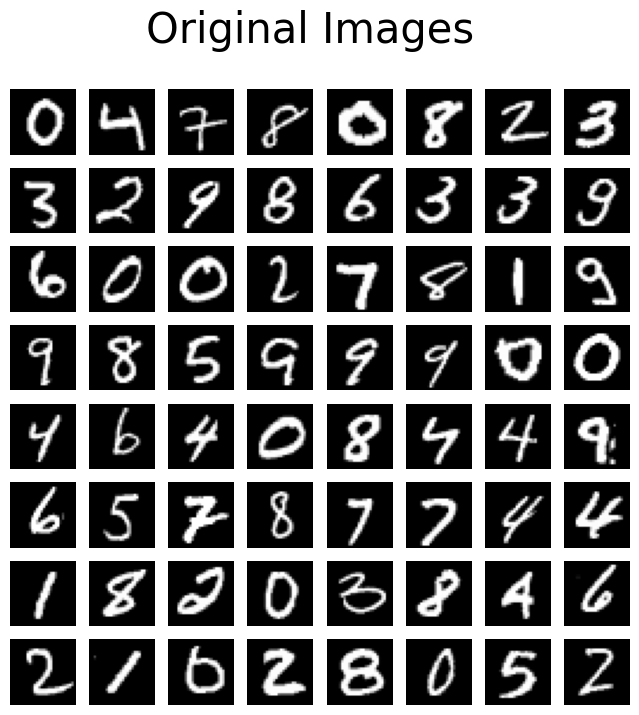

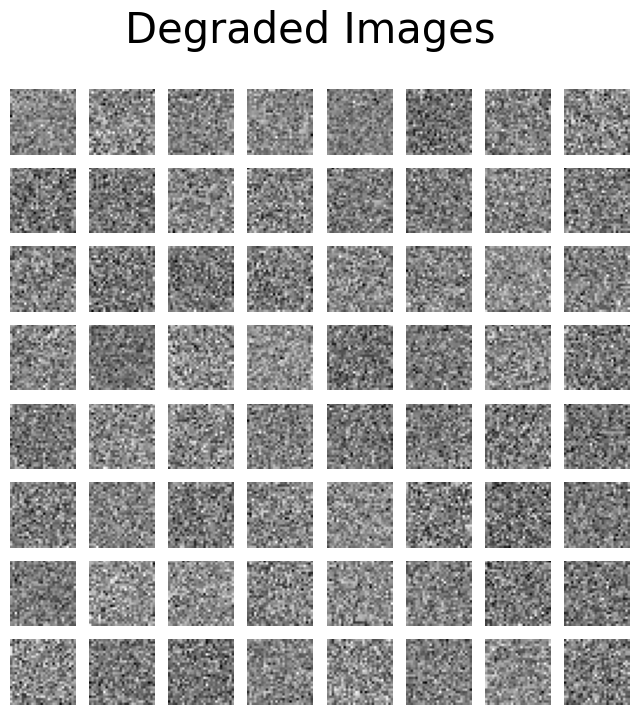

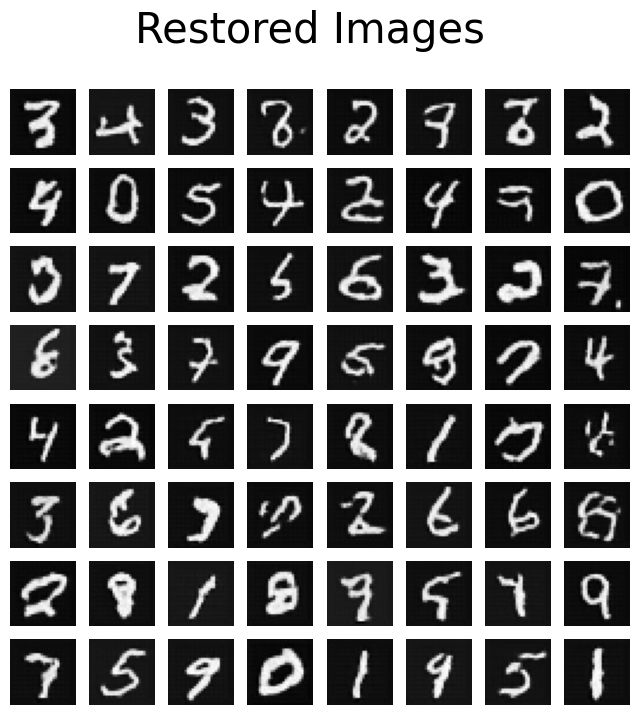

In [8]:
example_data, _ = next(iter(train_loader))
example_data = example_data.to(device)



degraded_example = degrade_image(example_data, torch.tensor(1.0).to(device))
restored_example = restore_image(model, degraded_example)


show_images(example_data, title="Original Images")

show_images(degraded_example, title="Degraded Images")

show_images(restored_example, title="Restored Images")

In [5]:

optimizer = optim.Adam(model.parameters(), lr=0.001)

def degrade_image(image, t):
    noise = torch.randn_like(image)
    t = t.view(-1, 1, 1, 1).expand_as(image)
    return (1 - t) * image + t * noise + torch.randn_like(image, device=image.device) *0.01* torch.sqrt(t) *torch.sqrt(t)

epochs = 30

for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        data = data.to(device)
        t = torch.rand(data.size(0), device=data.device)
        degraded_data = degrade_image(data, t)
        optimizer.zero_grad()
        output = model(degraded_data, t)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

Epoch 1/30, Loss: 0.030446119606494904
Epoch 2/30, Loss: 0.028694361448287964
Epoch 3/30, Loss: 0.03687343746423721
Epoch 4/30, Loss: 0.035599883645772934
Epoch 5/30, Loss: 0.027027251198887825
Epoch 6/30, Loss: 0.03166605532169342
Epoch 7/30, Loss: 0.03368060290813446
Epoch 8/30, Loss: 0.022718867287039757
Epoch 9/30, Loss: 0.02949799783527851
Epoch 10/30, Loss: 0.02654074877500534
Epoch 11/30, Loss: 0.030629588291049004
Epoch 12/30, Loss: 0.04009868949651718
Epoch 13/30, Loss: 0.034279923886060715
Epoch 14/30, Loss: 0.02613675221800804
Epoch 15/30, Loss: 0.03641591593623161
Epoch 16/30, Loss: 0.025420276448130608
Epoch 17/30, Loss: 0.028400778770446777
Epoch 18/30, Loss: 0.02971571311354637
Epoch 19/30, Loss: 0.038106635212898254
Epoch 20/30, Loss: 0.029222488403320312
Epoch 21/30, Loss: 0.023902464658021927
Epoch 22/30, Loss: 0.025201033800840378
Epoch 23/30, Loss: 0.02841908298432827
Epoch 24/30, Loss: 0.03170132637023926
Epoch 25/30, Loss: 0.03215942159295082
Epoch 26/30, Loss: 0.

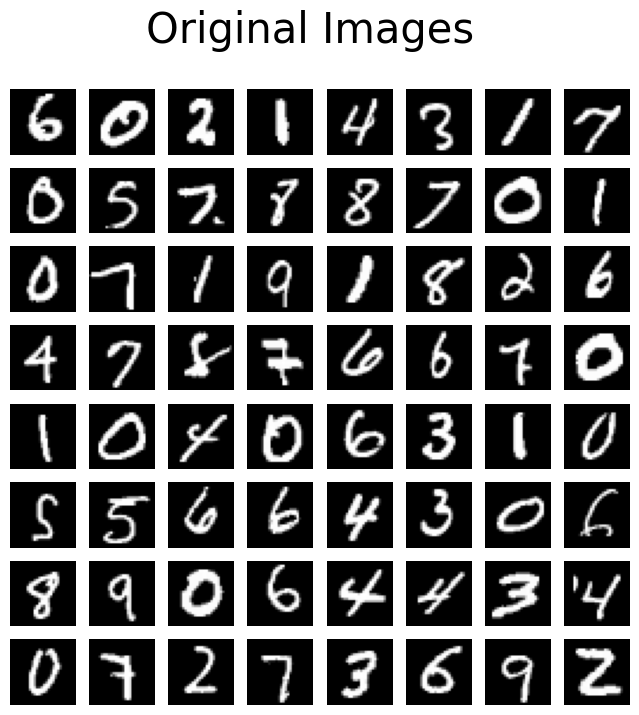

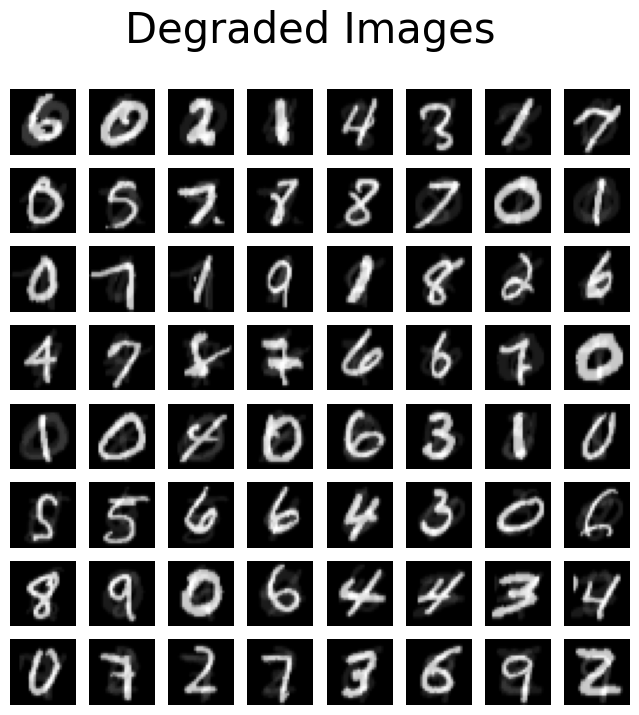

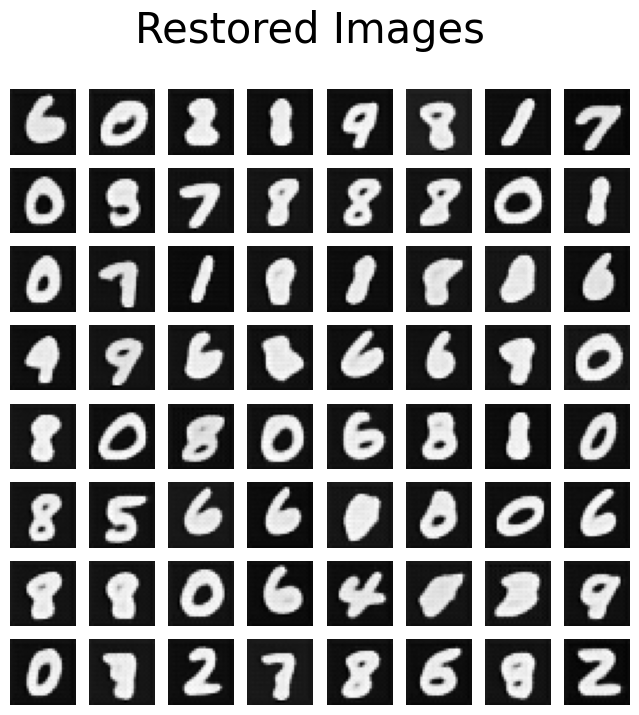

In [7]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""
    images = [im.cpu().permute(1,2,0).numpy() for im in images]

    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx], cmap="gray")
                plt.axis('off')
                idx += 1
    fig.suptitle(title, fontsize=30)

    plt.show()


example_data, _ = next(iter(train_loader))
example_data = example_data.to(device)

kernel_size = 3
degraded_example = cv2.GaussianBlur(example_data.cpu().numpy().squeeze() , (kernel_size, kernel_size), sigmaX=0.5)
degraded_example = torch.tensor(degraded_example).unsqueeze(1).cuda()


restored_example = restore_image(model, degraded_example)


show_images(example_data, title="Original Images")

show_images(degraded_example, title="Degraded Images")

show_images(restored_example, title="Restored Images")